In [29]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2, heyoka_ffnn, build_taylor_ffnn

# PyTorch and ML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Main imports
import heyoka as hy
import pykep as pk
import pandas as pd

# Usual imports
import time
import numpy as np
from scipy.integrate import odeint
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

# Jupyter setup
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model definition (loading the G&CNET)

In [6]:
# A FFNN with continuous activation functions (softplus)
neurons = 700
model = nn.Sequential(
          nn.Linear(6,neurons),
          nn.Softplus(),
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,neurons),
          nn.Softplus(),
          nn.Linear(neurons,3),
        )
model.cpu()

Sequential(
  (0): Linear(in_features=6, out_features=700, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=700, out_features=700, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=700, out_features=700, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=700, out_features=700, bias=True)
  (7): Softplus(beta=1, threshold=20)
  (8): Linear(in_features=700, out_features=3, bias=True)
)

In [7]:
model.load_state_dict(torch.load("data/training_50000_100_[0.001, 0.001, 0.08, 0.08]_[1.0, 1.0, 1.0, 1.0].pk_300_epochs_4_layers_700_neurons_4096_batch_size_loss2.mdl"))

<All keys matched successfully>

# Loading the test set
### Note that test set needs to be generated with an extra entry (to account for variable time of flight) compared to the training dataset

In [8]:
with open("data/test_4_189_250_100_[0.001, 0.001, 0.001, 0.001]_[1.0, 1.0, 1.0, 1.0].pk", "rb") as file:
    data = pkl.load(file)

In [9]:
# This was defined early on in other notebooks and here hardcoded (careful)
r_target = 1.3 * pk.AU
# Problem data
GAMMA = 1e-4
OMEGA = np.sqrt(pk.MU_SUN/r_target**3) 

In [10]:
traj_id = 24
# We load the data for one particular trajectory
state = data[traj_id][:,:6]
thrust = data[traj_id][:,6:9]
ic = state[-1]
tof  = data[traj_id][0,-1]

# Using scipy integrator (good enough for this as precision required is low)

In [11]:
def dxdt(x, t, model):
    L = pk.AU
    TIME = np.sqrt(L**3/pk.MU_SUN)   # Unit for time (period)
    ACC = L/TIME**2                  # Unit for accelerations
    # Non-dimensionalize:
    mu = 1.
    ndGAMMA = GAMMA / ACC
    ndOMEGA = OMEGA * TIME
    #print(type(x))
    inp = torch.tensor(x).float()
    #print(inp)
    ix, iy, iz = model(inp).detach()
    norm = np.sqrt(ix**2 + iy**2 + iz**2)
    ix = ix / norm
    iy = iy / norm
    iz = iz / norm
    dxdt = [0]*6
    dxdt[0] = x[3]
    dxdt[1] = x[4]
    dxdt[2] = x[5]
    dxdt[3] = -mu*x[0]/((x[0]**2+x[1]**2+x[2]**2)**(3/2)) + 2*ndOMEGA*x[4] + ndOMEGA**2*x[0] + ndGAMMA*ix
    dxdt[4] = -mu*x[1]/((x[0]**2+x[1]**2+x[2]**2)**(3/2)) - 2*ndOMEGA*x[3] + ndOMEGA**2*x[1] + ndGAMMA*iy
    dxdt[5] = -mu*x[2]/((x[0]**2+x[1]**2+x[2]**2)**(3/2)) + ndGAMMA*iz
    return dxdt

In [12]:
tgrid = np.linspace(0, tof, 100)
scipy_sol = odeint(dxdt, ic, tgrid, args=(model,), rtol=1e-9,atol=1e-9)
err_r = np.linalg.norm(scipy_sol[-1,:3] - state[0,:3])
err_v = np.linalg.norm(scipy_sol[-1,3:6] - state[0,3:6])
print(f"r: {err_r}, v: {err_v}")

r: 0.0009313044237798863, v: 0.0013304789337964828


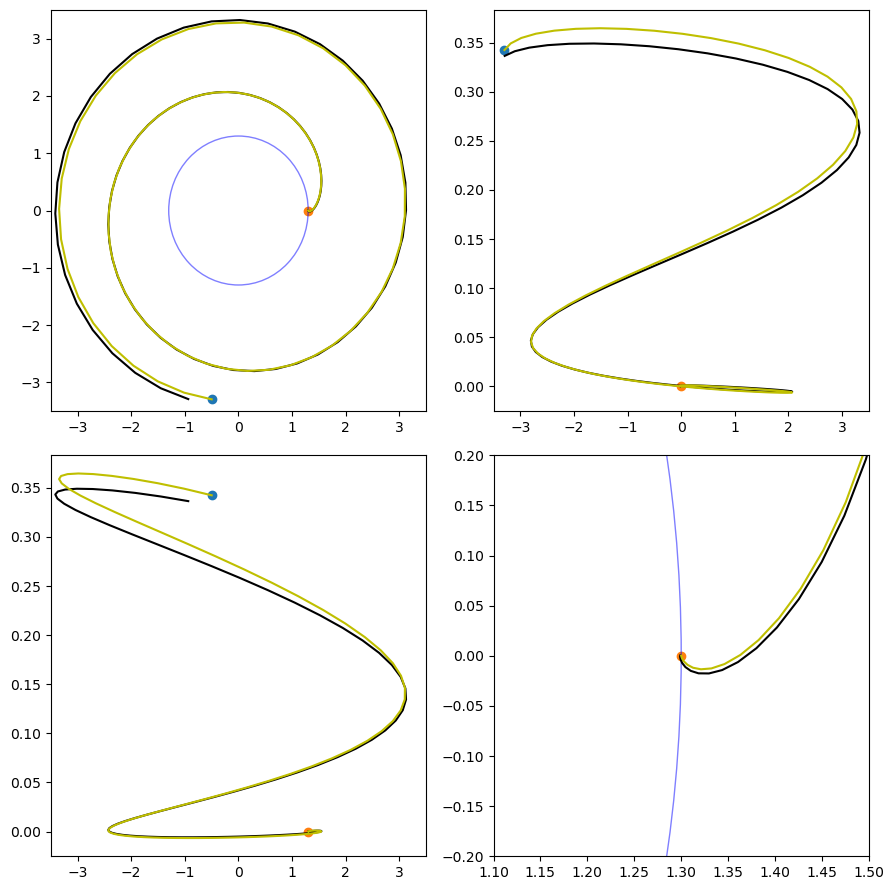

In [30]:
# Visualize
fig = plt.figure(figsize= (9,9))

ax1 = fig.add_subplot(2,2, 1)
ax1.plot(scipy_sol[:,0], scipy_sol[:,1], 'k')
ax1.plot(state[:,0], state[:,1], 'y')

ax1.scatter(state[-1,0], state[-1,1])
ax1.scatter(state[0,0], state[0,1])
circle = plt.Circle((0, 0), 1.3, color='b', fill=False, alpha=0.5)
ax1.add_patch(circle)
ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)
ax1.axis('on')

ax2 = fig.add_subplot(2,2, 2)
ax2.plot(scipy_sol[:,1], scipy_sol[:,2], 'k')
ax2.plot(state[:,1], state[:,2], 'y')
ax2.scatter(state[-1,1], state[-1,2])
ax2.scatter(state[0,1], state[0,2])
ax2.set_xlim(-3.5,3.5)
ax2.axis('on')

ax3 = fig.add_subplot(2,2, 3)
ax3.plot(scipy_sol[:,0], scipy_sol[:,2], 'k')
ax3.plot(state[:,0], state[:,2], 'y')
ax3.scatter(state[-1,0], state[-1,2])
ax3.scatter(state[0,0], state[0,2])
ax3.set_xlim(-3.5,3.5)
ax3.axis('on')

ax4 = fig.add_subplot(2,2, 4)
ax4.plot(scipy_sol[:,0], scipy_sol[:,1], 'k')
ax4.plot(state[:,0], state[:,1], 'y')

ax4.scatter(state[-1,0], state[-1,1])
ax4.scatter(state[0,0], state[0,1])
circle = plt.Circle((0, 0), 1.3, color='b', fill=False, alpha=0.5)
ax4.add_patch(circle)
ax4.set_xlim(1.1,1.5)
ax4.set_ylim(-0.2,0.2)
ax4.axis('on')

plt.tight_layout()

In [14]:
err_r = np.linalg.norm(scipy_sol[-1,:3] - state[0,:3])
err_v = (np.linalg.norm(scipy_sol[-1,3:6] - state[0,3:6]))
r = scipy_sol[-1,:3] * pk.AU
v = scipy_sol[-1,3:6] * np.sqrt(pk.MU_SUN/pk.AU)
# We move the velocity to the inertial frame
v[0] = v[0] - OMEGA * r[1]
v[1] = v[1] + OMEGA * r[0]
# Convert to equinoctial
E = pk.ic2eq(r,v, pk.MU_SUN)
ecc_final = np.sqrt(E[1]**2+E[2]**2)
err_a = (E[0]/(1-ecc_final**2) - r_target)
err_e = (np.sqrt(E[1]**2+E[2]**2))
err_i = (2*np.arctan(np.sqrt(E[3]**2+E[4]**2)))

print(f"Error on final position  (AU): {np.mean(err_r)*pk.AU/pk.AU}")
print(f"Error on final velocity  (km/s): {np.mean(err_v)*np.sqrt(pk.MU_SUN/pk.AU)/1000.}")
print(f"Error on final sma  (AU): {np.mean(err_a)/pk.AU}")
print(f"Error on final ecc: {np.mean(err_e)}")
print(f"Error on final incl  (degrees): {np.mean(err_i)*pk.RAD2DEG}")

Error on final position  (AU): 0.0009313044237798862
Error on final velocity  (km/s): 0.039627905032884804
Error on final sma  (AU): 0.00024538375818678447
Error on final ecc: 0.001003047025025217
Error on final incl  (degrees): 0.01717761227341277


# We do the same in heyoka
Te advantage of Heyoka is in the event machinery usage. Here we can stop when the sma is reached

In [15]:
n_in = 6
n_out = 3
n_hidden = 4
n_neurons_per_layer = 700
thrust_ffnn = heyoka_ffnn(n_in, n_out, n_hidden, n_neurons_per_layer)

# Need weights and biases converted to numpy and pickled
state_dict_numpy = dict()
for key in model.state_dict():
    state_dict_numpy[key] = model.state_dict()[key].cpu().numpy()
      
# Import weight and bias into the ffnn representation in heyoka
thrust_ffnn.set_parameters_from_torch(state_dict_numpy)

# Definition of the Heyoka Integrator

In [16]:
# This activates the stopping condition at sma.
def sma_callback(ta, mr, d_sgn):
    return False

In [17]:
# Do this only once
ta = build_taylor_ffnn(pk.AU, pk.MU_SUN, GAMMA, OMEGA, thrust_ffnn, sma_callback=sma_callback, tol=1e-6)

In [18]:
# Weights and biases are initialized  in the Taylor Adaptive Integrator
ta.pars[:] = thrust_ffnn.par
ta.state[:] = ic
ta.time = 0.

In [19]:
tgrid = np.linspace(0, tof*1.05, 1000)
sol_ta = ta.propagate_grid(tgrid)[4]

In [20]:
err_r = np.linalg.norm(ta.state[:3] - state[0,:3])
err_v = (np.linalg.norm(ta.state[3:] - state[0,3:6]))
r = ta.state[:3] * pk.AU
v = ta.state[3:] * np.sqrt(pk.MU_SUN/pk.AU)
# We move the velocity to the inertial frame
v[0] = v[0] - OMEGA * r[1]
v[1] = v[1] + OMEGA * r[0]
# Convert to equinoctial
E = pk.ic2eq(r,v, pk.MU_SUN)
ecc_final = np.sqrt(E[1]**2+E[2]**2)
err_a = (E[0]/(1-ecc_final**2) - r_target)
err_e = ecc_final
err_i = (2*np.arctan(np.sqrt(E[3]**2+E[4]**2)))

print(f"Error on final position  (AU): {err_r}")
print(f"Error on final velocity  (km/s): {err_v*np.sqrt(pk.MU_SUN/pk.AU)/1000}")
print(f"Error on final sma  (AU): {err_a/pk.AU}")
print(f"Error on final ecc: {err_e}")
print(f"Error on final incl  (degrees): {err_i*pk.RAD2DEG}")

Error on final position  (AU): 0.0009265615902790337
Error on final velocity  (km/s): 0.037370280919553196
Error on final sma  (AU): -1.426349888968287e-12
Error on final ecc: 0.0008572543545933747
Error on final incl  (degrees): 0.017209187175113237


# Here we produce the same analysis for the trajectories in the dataset. We propagate for tf. (use scipy as its faster for this)

In [21]:
# We loop over all the test set and compute the errors
tgrid = np.linspace(0, tof, 100)
# Error on the norm of the final position
err_r = []
# Error on the norm of the final velocity
err_v = []
# Error on the norm of the final sma
err_a = []
# Error on the norm of the final inclination
err_i = []
# Error on the norm of the final eccentricity
err_e = []
for traj in tqdm(data):
    # We loop over all the test set and compute the errors
    tof  = traj[0,-1]
    tgrid = np.linspace(0, tof, 100)
    # We load the data for one particular trajectory
    state = traj[:,:6]
    thrust = traj[:,6:9]
    ic = state[-1]
    scipy_sol = odeint(dxdt, ic, tgrid, args=(model,), atol=1e-6, rtol=1e-6)
    err_r.append(np.linalg.norm(scipy_sol[-1,:3] - state[0,:3]))
    err_v.append(np.linalg.norm(scipy_sol[-1,3:6] - state[0,3:6]))
    r = scipy_sol[-1,:3] * pk.AU
    v = scipy_sol[-1,3:6] * np.sqrt(pk.MU_SUN/pk.AU)
    # We move the velocity to the inertial frame
    v[0] = v[0] - OMEGA * r[1]
    v[1] = v[1] + OMEGA * r[0]
    # Convert to equinoctial
    E = pk.ic2eq(r,v, pk.MU_SUN)
    ecc_final = np.sqrt(E[1]**2+E[2]**2)
    err_a.append(E[0]/(1-ecc_final**2) - r_target)
    err_e.append(np.sqrt(E[1]**2+E[2]**2))
    err_i.append(2*np.arctan(np.sqrt(E[3]**2+E[4]**2)))

100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]


In [22]:
print(f"Error on final position  (AU): {np.mean(err_r)*pk.AU/pk.AU}")
print(f"Error on final velocity  (km/s): {np.mean(err_v)*np.sqrt(pk.MU_SUN/pk.AU)/1000}")
print(f"Error on final sma  (AU): {np.mean(err_a)/pk.AU}")
print(f"Error on final ecc: {np.mean(err_e)}")
print(f"Error on final incl  (degrees): {np.mean(err_i)*pk.RAD2DEG}")

Error on final position  (AU): 0.0032002285232774507
Error on final velocity  (km/s): 0.1326830678508775
Error on final sma  (AU): 0.001225553616196279
Error on final ecc: 0.004829071619837203
Error on final incl  (degrees): 0.028018974444913018


# Here we produce the same analysis for the trajectories in the dataset. We propagate for tf. (use heyoka as it stops at target sma)

In [23]:
# Error on the norm of the final position
err_r = []
# Error on the norm of the final velocity
err_v = []
# Error on the norm of the final sma
err_a = []
# Error on the norm of the final inclination
err_i = []
# Error on the norm of the final eccentricity
err_e = []
#
err_time = []
for traj in tqdm(data[:100]):
    # We load the data for one particular trajectory
    tof  = traj[0,-1]
    state = traj[:,:6]
    thrust = traj[:,6:9]
    ic = state[-1]
    # Reset the taylor adaptive
    ta.state[:] = ic
    ta.time = 0.
    ta.propagate_until(tof*1.05)
    # Compute the errors
    err_r.append(np.linalg.norm(ta.state[:3] - state[0,:3]))
    err_v.append(np.linalg.norm(ta.state[3:6] - state[0,3:6]))
    r = ta.state[:3] * pk.AU
    v = ta.state[3:6] * np.sqrt(pk.MU_SUN/pk.AU)
    # We move the velocity to the inertial frame
    v[0] = v[0] - OMEGA * r[1]
    v[1] = v[1] + OMEGA * r[0]
    # Convert to equinoctial
    E = pk.ic2eq(r,v, pk.MU_SUN)
    ecc_final = np.sqrt(E[1]**2+E[2]**2)
    err_a.append(E[0]/(1-ecc_final**2) - r_target)
    err_e.append(np.sqrt(E[1]**2+E[2]**2))
    err_i.append(2*np.arctan(np.sqrt(E[3]**2+E[4]**2)))
    err_time.append( (ta.time -tof)*np.sqrt(pk.AU**3/pk.MU_SUN)*pk.SEC2DAY/365.25 )

100%|██████████| 100/100 [11:59<00:00,  7.19s/it]


In [24]:
print(f"Error on final position  (AU): {np.mean(err_r)*pk.AU/pk.AU}")
print(f"Error on final velocity  (km/s): {np.mean(err_v)*np.sqrt(pk.MU_SUN/pk.AU)/1000}")
print(f"Error on final sma  (AU): {np.mean(err_a)/pk.AU}")
print(f"Error on final ecc: {np.mean(err_e)}")
print(f"Error on final incl  (degrees): {np.mean(err_i)*pk.RAD2DEG}")
print(f"Error on final time  (years): {np.mean(err_time)}")

Error on final position  (AU): 0.0033803479443971474
Error on final velocity  (km/s): 0.1338226090455638
Error on final sma  (AU): -4.5697655595491896e-11
Error on final ecc: 0.00475054940743872
Error on final incl  (degrees): 0.029409467161679574
Error on final time  (years): 0.004211979189162976


# We compute the average error on the predictions

In [40]:
data.shape

(1000, 100, 10)

In [41]:
# Compute the average error on the predciton of the testset
action = data.reshape(1000 * 100, 10)[:,6:9]
state = data.reshape(1000*100, 10)[:, :6]

In [42]:
prediction = model(torch.tensor(state).float())

In [43]:
# The loss is the cosine of the angle between the predicted and the actual thrust vector
cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
def loss1(ground_truth, prediction):    
    return torch.arccos(torch.mean(cosine_similarity(ground_truth, prediction))) / np.pi * 180

In [44]:
l = loss1(torch.tensor(action).float(), prediction)

In [45]:
print(f"Average error (degrees): ", l.item() )

Average error (degrees):  0.8873521089553833
